Package 'ucimlrepo' non trouvé. Installation en cours...
Installation de 'ucimlrepo' terminée.
Téléchargement du dataset (ID=222) depuis UCI...

--- Type de l'objet retourné par fetch_ucirepo ---
<class 'ucimlrepo.dotdict.dotdict'>

--- Métadonnées (si disponibles) ---
{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing

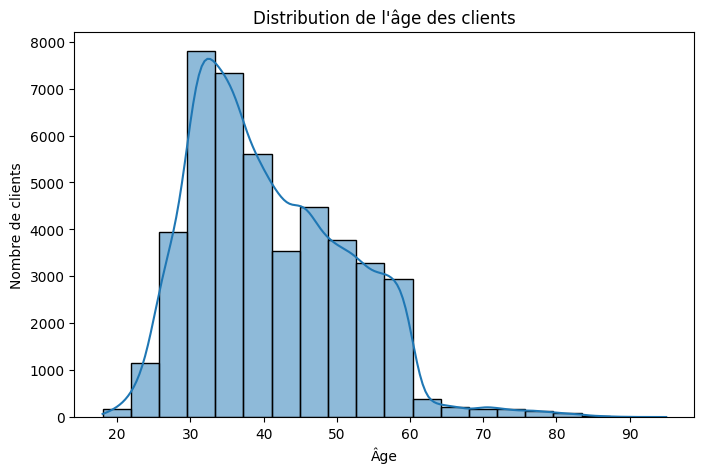

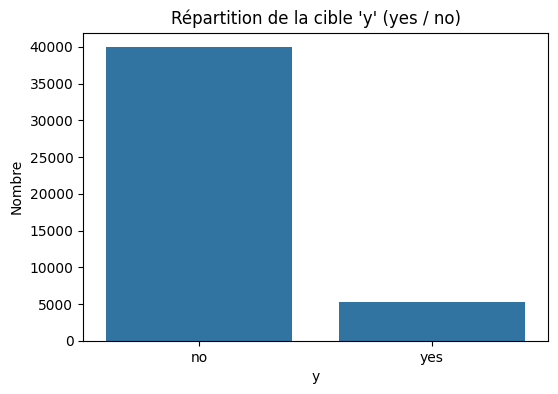


Script terminé.


In [1]:
# === Script robuste pour charger et analyser le dataset Bank Marketing (ID=222) ===

import importlib
import subprocess
import sys

# Installer ucimlrepo si non présent
def ensure_package(pkg_name):
    try:
        importlib.import_module(pkg_name)
    except ImportError:
        print(f"Package '{pkg_name}' non trouvé. Installation en cours...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])
        print(f"Installation de '{pkg_name}' terminée.")

ensure_package("ucimlrepo")
ensure_package("pandas")
ensure_package("matplotlib")
ensure_package("seaborn")

# Imports après installation éventuelle
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le dataset (ID 222)
print("Téléchargement du dataset (ID=222) depuis UCI...")
bank_marketing = fetch_ucirepo(id=222)

# Inspecter l'objet retourné pour déterminer où sont les features/targets
print("\n--- Type de l'objet retourné par fetch_ucirepo ---")
print(type(bank_marketing))

# Afficher métadonnées si disponibles
print("\n--- Métadonnées (si disponibles) ---")
if hasattr(bank_marketing, "metadata"):
    print(bank_marketing.metadata)
else:
    print("Pas de champ 'metadata' trouvé.")

# Afficher description des variables si disponibles
print("\n--- Variables (si disponibles) ---")
if hasattr(bank_marketing, "variables"):
    print(bank_marketing.variables)
else:
    print("Pas de champ 'variables' trouvé.")

# Récupérer features X et target y de façon robuste
X = None
y = None

# Méthode 1 : accès attendu (bank_marketing.data.features / bank_marketing.data.targets)
try:
    data_container = bank_marketing.data
    # Certains retours peuvent donner .features et .targets
    if hasattr(data_container, "features") and hasattr(data_container, "targets"):
        X = data_container.features
        y = data_container.targets
        print("\nDonnées chargées via bank_marketing.data.features / .targets")
    # d'autres peuvent avoir .data et .target
    elif hasattr(data_container, "data") and hasattr(data_container, "target"):
        X = pd.DataFrame(data_container.data)
        y = pd.Series(data_container.target, name="target")
        print("\nDonnées chargées via bank_marketing.data.data / .target")
    else:
        # si data_container est déjà un DataFrame ou dict
        if isinstance(data_container, pd.DataFrame):
            X = data_container.copy()
            print("\nbank_marketing.data est un DataFrame -> utilisé comme X (sans target séparé).")
        elif isinstance(data_container, dict):
            # tenter d'extraire 'features'/'targets' clés
            if "features" in data_container and "targets" in data_container:
                X = pd.DataFrame(data_container["features"])
                y = pd.DataFrame(data_container["targets"])
                print("\nDonnées chargées depuis dict data['features']/data['targets'].")
except Exception as e:
    print("Erreur lors de la lecture de bank_marketing.data :", str(e))

# Méthode 2 : accès direct sur l'objet retourné (si pas encore trouvé)
if X is None or y is None:
    # tester attributs directs
    if hasattr(bank_marketing, "data"):
        maybe = bank_marketing.data
        if isinstance(maybe, pd.DataFrame):
            X = maybe.copy()
    if hasattr(bank_marketing, "targets") and y is None:
        y = bank_marketing.targets
    if hasattr(bank_marketing, "target") and y is None:
        y = bank_marketing.target

# Si toujours rien, tenter lecture du csv si url disponible dans metadata
if X is None:
    # essayer d'extraire une URL depuis metadata
    url = None
    if hasattr(bank_marketing, "metadata") and isinstance(bank_marketing.metadata, dict):
        # chercher des champs communs
        for key in ("url", "data_url", "source", "file"):
            if key in bank_marketing.metadata and isinstance(bank_marketing.metadata[key], str):
                url = bank_marketing.metadata[key]
                break
    if url:
        try:
            print(f"\nTentative de chargement direct depuis l'URL trouvée dans metadata: {url}")
            X = pd.read_csv(url, sep=';')
        except Exception as e:
            print("Échec du chargement depuis l'URL:", e)

# Dernier recours : certaines versions renvoient un tuple (features, targets)
if X is None:
    try:
        # essayer d'interpréter l'objet comme tuple/list
        if isinstance(bank_marketing, (list, tuple)) and len(bank_marketing) >= 2:
            X = pd.DataFrame(bank_marketing[0])
            y = pd.Series(bank_marketing[1], name="target")
            print("\nDonnées chargées depuis tuple retourné (bank_marketing[0], bank_marketing[1]).")
    except Exception:
        pass

# Vérifier et convertir X/y en DataFrame/Series
if X is None:
    raise RuntimeError("Impossible de localiser les features (X). Vérifie la version de ucimlrepo et la connexion internet.")
if not isinstance(X, pd.DataFrame):
    try:
        X = pd.DataFrame(X)
    except Exception as e:
        raise RuntimeError("Impossible de convertir X en DataFrame : " + str(e))

if y is None:
    # si pas de y séparé, vérifier si la colonne 'y' existe dans X (cas du CSV bank.csv)
    if 'y' in X.columns:
        y = X['y'].copy()
        X = X.drop(columns=['y'])
        print("La colonne 'y' a été trouvée dans X et utilisée comme cible.")
    else:
        print("Aucune cible (y) séparée trouvée. Le DataFrame final contiendra uniquement X.")
else:
    # si y est DataFrame, convertir en Series si possible
    if isinstance(y, pd.DataFrame) and y.shape[1] == 1:
        y = y.iloc[:, 0]
    if not isinstance(y, pd.Series):
        try:
            y = pd.Series(y, name='y')
        except Exception as e:
            print("Impossible de convertir y en Series :", e)
            y = None

# Construire DataFrame final
if y is not None:
    df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
else:
    df = X.copy()

# Afficher aperçu et informations
print("\n=== Aperçu du DataFrame final ===")
print(df.head())
print("\n=== Info ===")
print(df.info())

print("\n=== Statistiques descriptives (numériques) ===")
print(df.describe())

# Exemple d'analyse : si 'age' existe -> statistiques + histogramme
if 'age' in df.columns:
    age = df['age'].dropna().astype(float)
    print("\n--- Statistiques sur 'age' ---")
    print(f"Moyenne: {age.mean():.2f}")
    print(f"Médiane: {age.median():.2f}")
    print(f"Mode: {age.mode().iloc[0] if not age.mode().empty else 'N/A'}")
    print(f"Écart-type: {age.std():.2f}")
    print(f"Min: {age.min():.2f}, Max: {age.max():.2f}")
    # Visualisation
    plt.figure(figsize=(8,5))
    sns.histplot(age, bins=20, kde=True)
    plt.title("Distribution de l'âge des clients")
    plt.xlabel("Âge")
    plt.ylabel("Nombre de clients")
    plt.show()
else:
    print("\nLa colonne 'age' n'existe pas dans le DataFrame final.")

# Visualisation de la cible y si présente
if 'y' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='y', data=df)
    plt.title("Répartition de la cible 'y' (yes / no)")
    plt.xlabel("y")
    plt.ylabel("Nombre")
    plt.show()
else:
    print("\nLa colonne 'y' n'existe pas dans le DataFrame final — pas de graphique de la cible possible.")

print("\nScript terminé.")


### Matrice de corrélation

Nous allons maintenant calculer et visualiser la matrice de corrélation pour les variables numériques du dataset. Cela nous aidera à comprendre les relations linéaires entre ces variables.

Matrice de corrélation (aperçu):
                  age   balance  day_of_week  duration  campaign     pdays  \
age          1.000000  0.097783    -0.009120 -0.004648  0.004760 -0.023758   
balance      0.097783  1.000000     0.004503  0.021560 -0.014578  0.003435   
day_of_week -0.009120  0.004503     1.000000 -0.030206  0.162490 -0.093044   
duration    -0.004648  0.021560    -0.030206  1.000000 -0.084570 -0.001565   
campaign     0.004760 -0.014578     0.162490 -0.084570  1.000000 -0.088628   

             previous  
age          0.001288  
balance      0.016674  
day_of_week -0.051710  
duration     0.001203  
campaign    -0.032855  


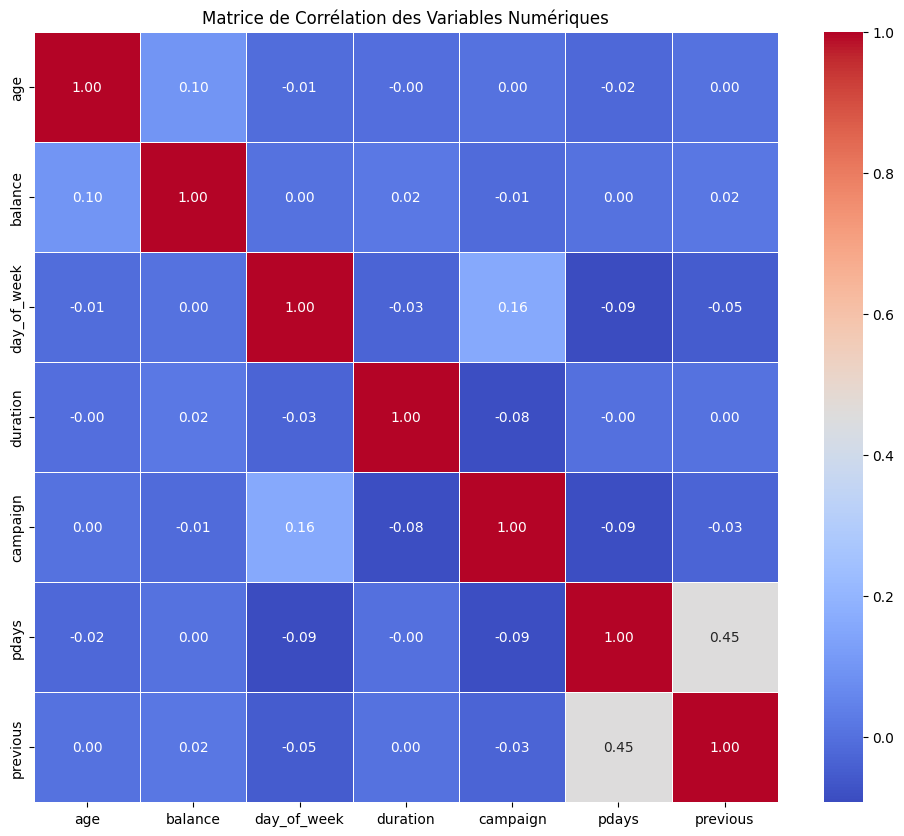

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionner uniquement les colonnes numériques pour la corrélation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Calculer la matrice de corrélation
correlation_matrix = numeric_df.corr()

# Afficher la matrice de corrélation (premières lignes/colonnes si trop grande)
print("Matrice de corrélation (aperçu):")
print(correlation_matrix.head())

# Visualiser la matrice de corrélation avec une heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de Corrélation des Variables Numériques')
plt.show()